# Experiment Notebook: Numerosity-Based Categorization (One-Run Setup)

**Objective:**  
Train a CNN on the synthetic dot dataset (saved as `train_dataset.pt`, `val_dataset.pt`, and `test_dataset.pt`) to classify images into three categories (Few, Medium, Many).  

**Goals:**
- Run multiple experiments (5+ runs) to account for randomness.
- Perform hyperparameter tuning.
- Record results in tables and visualize training curves, confusion matrices, and classification reports.
- Use a validation set for hyperparameter tuning.

**Configuration**
- Seed: 42
- Learning Rate: 0.0002
- Batch Size: 256
- Epochs: 20 (with early stopping)


# Set Seed for Reproducibility

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior on cuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


# Import Libraries and Setup Device

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Load Saved Datasets

In [ ]:
from torch.utils.data import Dataset

class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")


# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt")
val_dataset = torch.load("val_dataset.pt")
test_dataset = torch.load("test_dataset.pt")

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 3500
Validation Dataset Size: 750
Test Dataset Size: 750


# Define the Model Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class NumerosityCNN(nn.Module):
    def __init__(self):
        super(NumerosityCNN, self).__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        # Input size 128x128 becomes 16x16 after 3 rounds of 2x2 pooling.
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 3)  # Three classes: Few, Medium, Many

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out)

# Training and Evaluation Functions

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=2):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps  # Scale loss for accumulation
        loss.backward()  # Backpropagation

        # Perform optimizer step every `accumulation_steps` iterations
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()  # Reset gradients

        running_loss += loss.item() * accumulation_steps  # Reverse scaling for correct loss tracking

    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    return avg_loss, accuracy, all_labels, all_preds

def run_experiment(num_epochs=20, learning_rate=0.0002, batch_size=256, early_stop_patience=5, accumulation_steps=2):

    set_seed(42)

    # Create DataLoaders for the current run (can vary batch_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = NumerosityCNN().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-4, eps=1e-6, betas=(0.9, 0.98))
    criterion = nn.CrossEntropyLoss()

    # To store the training history
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")

        # Early stopping check based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_accuracies

# Running Single Run Experiment

In [ ]:
print(f"\n--- Starting Experiment Run  ---")
model, train_losses, val_losses, val_accuracies = run_experiment(num_epochs=20, learning_rate=0.0002, batch_size=256)

print("\n--- Experiment Completed ---")


--- Starting Experiment Run  ---
Epoch [1/20], Train Loss: 2.8537, Val Loss: 1.1865, Val Acc: 17.20%
Epoch [2/20], Train Loss: 1.2068, Val Loss: 1.0061, Val Acc: 30.40%
Epoch [3/20], Train Loss: 0.5764, Val Loss: 0.4242, Val Acc: 82.00%
Epoch [4/20], Train Loss: 0.4017, Val Loss: 0.3074, Val Acc: 86.27%
Epoch [5/20], Train Loss: 0.3401, Val Loss: 0.2576, Val Acc: 89.33%
Epoch [6/20], Train Loss: 0.2889, Val Loss: 0.2345, Val Acc: 90.93%
Epoch [7/20], Train Loss: 0.2597, Val Loss: 0.2107, Val Acc: 91.07%
Epoch [8/20], Train Loss: 0.2408, Val Loss: 0.2035, Val Acc: 90.93%
Epoch [9/20], Train Loss: 0.2315, Val Loss: 0.1957, Val Acc: 91.87%
Epoch [10/20], Train Loss: 0.2128, Val Loss: 0.1892, Val Acc: 91.60%
Epoch [11/20], Train Loss: 0.1975, Val Loss: 0.1849, Val Acc: 91.87%
Epoch [12/20], Train Loss: 0.2048, Val Loss: 0.1839, Val Acc: 92.40%
Epoch [13/20], Train Loss: 0.1822, Val Loss: 0.1855, Val Acc: 93.07%
Epoch [14/20], Train Loss: 0.1791, Val Loss: 0.1789, Val Acc: 92.80%
Epoch [15

# Evaluation of Test set & visualization

Test Loss: 0.2144, Test Accuracy: 89.87%


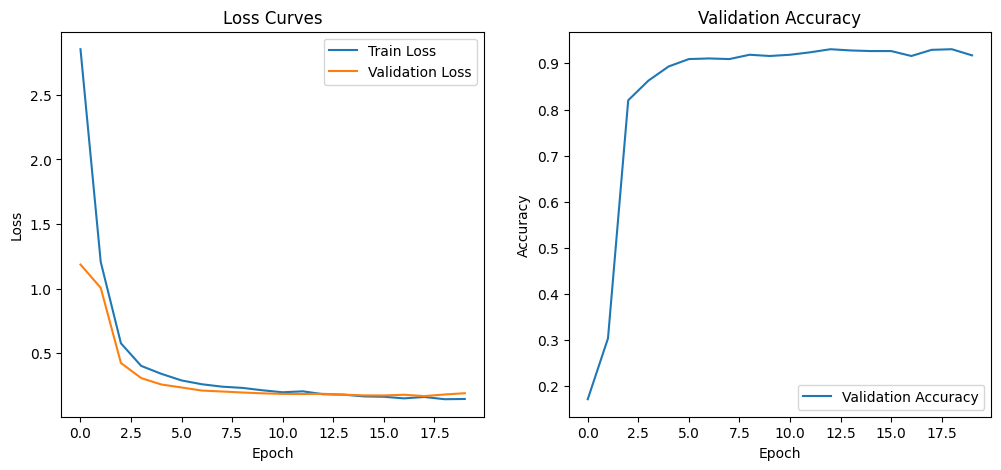

In [ ]:
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

# Confusion Matrix

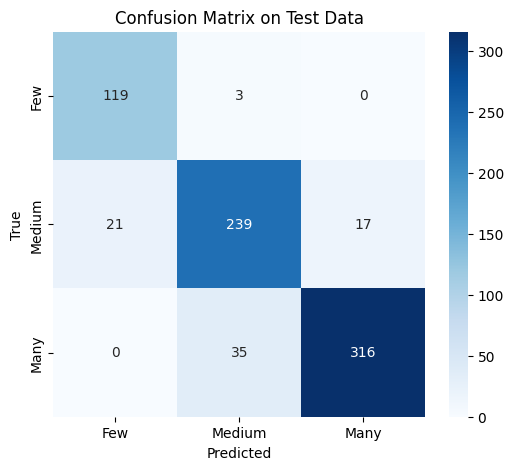

Classification Report:
              precision    recall  f1-score   support

         Few       0.85      0.98      0.91       122
      Medium       0.86      0.86      0.86       277
        Many       0.95      0.90      0.92       351

    accuracy                           0.90       750
   macro avg       0.89      0.91      0.90       750
weighted avg       0.90      0.90      0.90       750



In [ ]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Few", "Medium", "Many"], yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))

# Save final model & results

In [ ]:
torch.save(model.state_dict(), "final_numerosity_model.pt")
print("Final model saved as 'final_numerosity_model.pt'.")

results_dict = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
}
pd.DataFrame(results_dict).to_csv("experiment_results_run.csv", index=False)
print("Experiment results saved as 'experiment_results_run.csv'.")

Final model saved as 'final_numerosity_model.pt'.
Experiment results saved as 'experiment_results_run.csv'.


# Visualize Test Images with Predictions

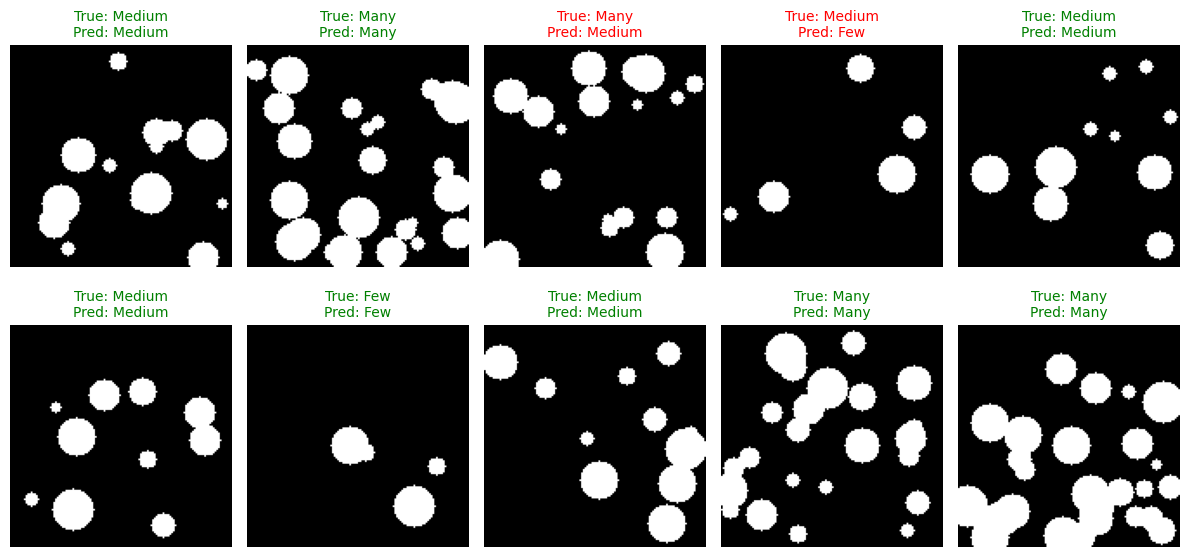

In [ ]:
# Get a batch of test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Map numeric labels to class names
label_names = {0: "Few", 1: "Medium", 2: "Many"}

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 sample test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    true_label = label_names[labels[i].item()]
    pred_label = label_names[predicted[i].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()